In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.phi_files = [f for f in os.listdir(data_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(data_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]
        
        # Sort the files to ensure correspondence between input and target files
        self.phi_files.sort()
        self.v_thresh_files.sort()

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        # Load the input vector (phi)
        phi_file = os.path.join(self.data_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        # Load the output scalar (v_thresh)
        v_thresh_file = os.path.join(self.data_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [2]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [16]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 5)
        self.fc5 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [17]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0, leave=True)
        for i, (inputs, targets) in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

def evaluate_model(model, train_loader, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    losses_over_train = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_train.append(loss.item())
    print(f'Train Loss: {total_loss / len(train_loader):.4f}')
    
    total_loss = 0.0
    losses_over_test = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_test.append(loss.item())
    print(f'Test Loss: {total_loss / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

In [35]:
data_dir = 'C:\\Users\\avp\\OneDrive - HKUST Connect\\Desktop\\Deep T-Rex\\Code\\RCode\\data'
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.0001,
           "num_epochs": 20}

train_loader, test_loader = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = nn.MSELoss()  # Mean squared error loss for regression
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

# Evaluate the model
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Epoch 1/20: 100%|██████████| 500/500 [00:03<00:00, 166.32it/s]


Epoch [1/20], Loss: 0.0620


Epoch 2/20: 100%|██████████| 500/500 [00:03<00:00, 155.19it/s]


Epoch [2/20], Loss: 0.0251


Epoch 3/20: 100%|██████████| 500/500 [00:03<00:00, 165.48it/s]


Epoch [3/20], Loss: 0.0224


Epoch 4/20: 100%|██████████| 500/500 [00:02<00:00, 166.94it/s]


Epoch [4/20], Loss: 0.0196


Epoch 5/20: 100%|██████████| 500/500 [00:03<00:00, 163.04it/s]


Epoch [5/20], Loss: 0.0173


Epoch 6/20: 100%|██████████| 500/500 [00:02<00:00, 169.03it/s]


Epoch [6/20], Loss: 0.0158


Epoch 7/20: 100%|██████████| 500/500 [00:02<00:00, 170.86it/s]


Epoch [7/20], Loss: 0.0150


Epoch 8/20: 100%|██████████| 500/500 [00:03<00:00, 162.92it/s]


Epoch [8/20], Loss: 0.0146


Epoch 9/20: 100%|██████████| 500/500 [00:02<00:00, 169.14it/s]


Epoch [9/20], Loss: 0.0142


Epoch 10/20: 100%|██████████| 500/500 [00:02<00:00, 169.96it/s]


Epoch [10/20], Loss: 0.0138


Epoch 11/20: 100%|██████████| 500/500 [00:03<00:00, 161.84it/s]


Epoch [11/20], Loss: 0.0133


Epoch 12/20: 100%|██████████| 500/500 [00:03<00:00, 163.22it/s]


Epoch [12/20], Loss: 0.0129


Epoch 13/20: 100%|██████████| 500/500 [00:03<00:00, 164.59it/s]


Epoch [13/20], Loss: 0.0125


Epoch 14/20: 100%|██████████| 500/500 [00:03<00:00, 166.00it/s]


Epoch [14/20], Loss: 0.0121


Epoch 15/20: 100%|██████████| 500/500 [00:02<00:00, 171.54it/s]


Epoch [15/20], Loss: 0.0116


Epoch 16/20: 100%|██████████| 500/500 [00:03<00:00, 161.24it/s]


Epoch [16/20], Loss: 0.0113


Epoch 17/20: 100%|██████████| 500/500 [00:03<00:00, 162.37it/s]


Epoch [17/20], Loss: 0.0108


Epoch 18/20: 100%|██████████| 500/500 [00:03<00:00, 166.25it/s]


Epoch [18/20], Loss: 0.0104


Epoch 19/20: 100%|██████████| 500/500 [00:03<00:00, 165.29it/s]


Epoch [19/20], Loss: 0.0100


Epoch 20/20: 100%|██████████| 500/500 [00:02<00:00, 166.90it/s]


Epoch [20/20], Loss: 0.0095
Train Loss: 0.0089
Test Loss: 0.0161


(array([ 4.,  2., 12., 20., 22., 37., 45., 62., 75., 65., 44., 28., 36.,
        22., 11.,  8.,  4.,  0.,  3.]),
 array([0.03271521, 0.03947455, 0.04623389, 0.05299323, 0.05975256,
        0.0665119 , 0.07327124, 0.08003057, 0.08678991, 0.09354925,
        0.10030859, 0.10706792, 0.11382726, 0.1205866 , 0.12734593,
        0.13410527, 0.14086461, 0.14762395, 0.15438328, 0.16114262]),
 <BarContainer object of 19 artists>)

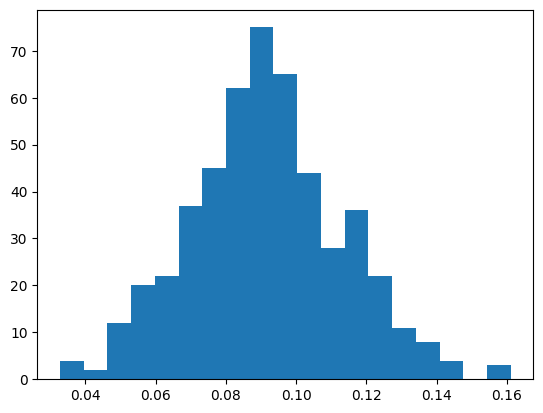

In [36]:
plt.hist(np.sqrt(losses_over_train), bins='auto')

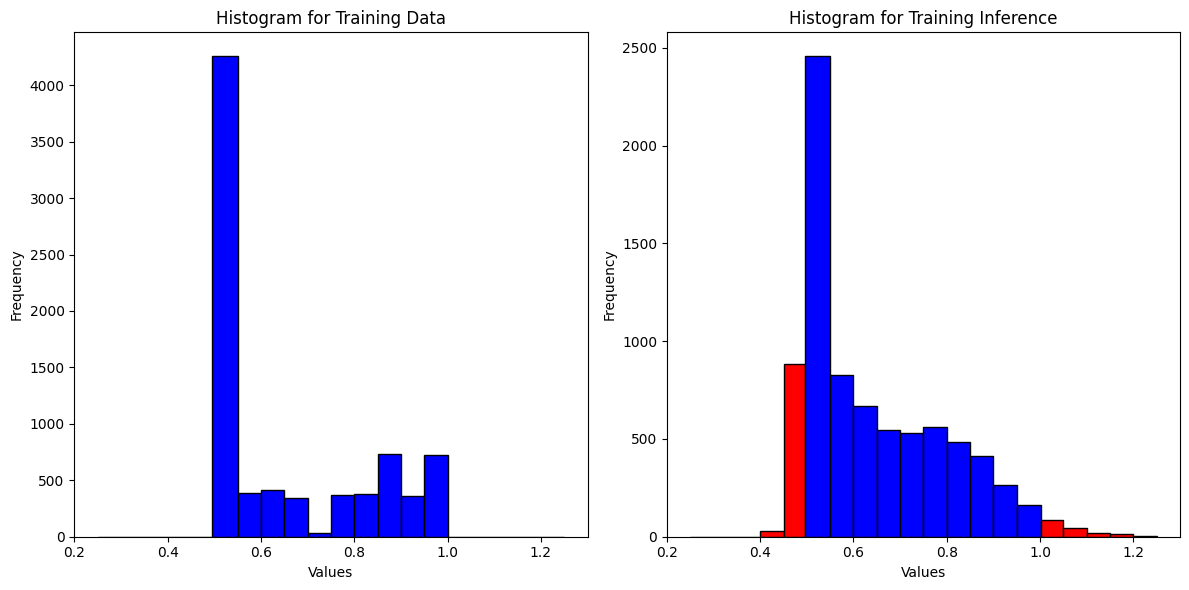

In [37]:
model.eval()

with torch.no_grad():
    total_train_loader = []
    for inputs, targets in train_loader:
        total_train_loader += targets.numpy().squeeze().tolist()
    
    total_train = []
    for inputs, targets in train_loader:
        total_train += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.495, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(total_train_loader, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(total_train, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

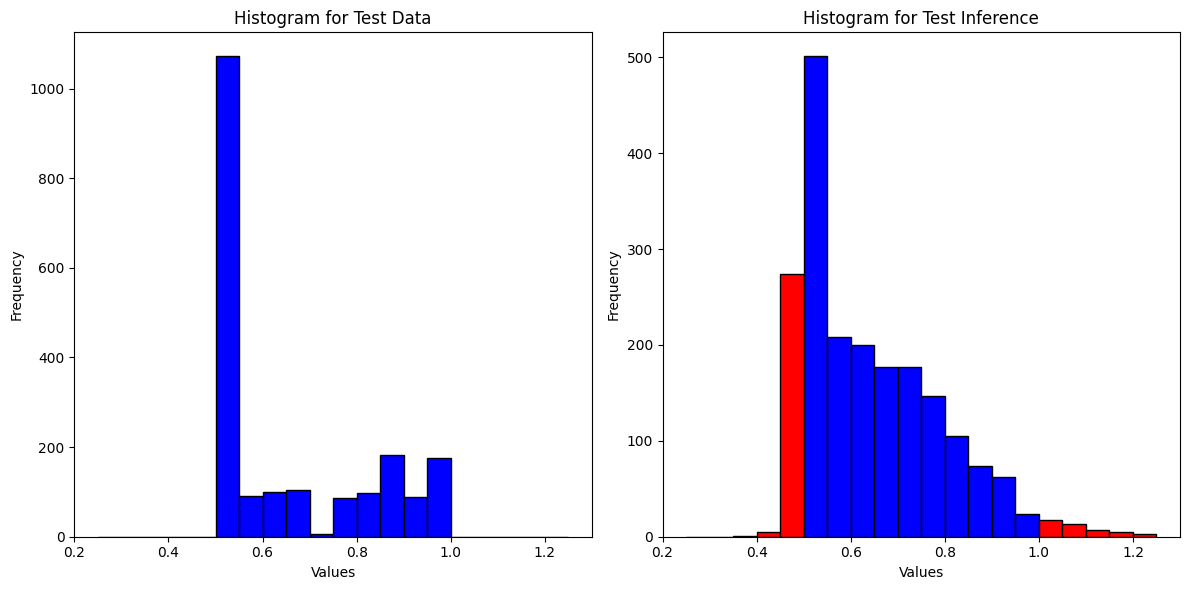

In [38]:
model.eval()

with torch.no_grad():
    total_test_loader = []
    for inputs, targets in test_loader:
        total_test_loader += targets.numpy().squeeze().tolist()
    
    total_test = []
    for inputs, targets in test_loader:
        total_test += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(total_test_loader, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(total_test, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()